## 표준 워크플로우 : compile(), fit(), evaluate(), predict()

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, train_labels,
         epochs=3,
         validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8665 - loss: 0.4544 - val_accuracy: 0.9566 - val_loss: 0.1500
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9519 - loss: 0.1668 - val_accuracy: 0.9680 - val_loss: 0.1149
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9631 - loss: 0.1319 - val_accuracy: 0.9709 - val_loss: 0.1065
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1152
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[워크플로우 커스터마이징 기법]
- 사용자 정의 측정 지표 전달
- fit() 메서드에 콜백을 전달하여 훈련하는 동안 특정 시점에 수행될 행동 예약

## 1. 사용자 정의 지표 만들기

- keras.metrics 모듈에 포함되어 있지 않은 지표의 경우 사용자 정의
- 케라스 지표는 keras.metrics.Metric 클래스를 상속한 클래스
- 층과 마찬가지로 지표는 텐서플로 변수에 내부 상태 저장
- 층과 다른 점은 이 변수가 역전파로 업데이트되지 않음 -> 상태 업데이트 로직을 update_state() 메서드 안에 직접 작성

### Metric 클래스를 상속하여 RMSE 사용자 정의 지표 구현

In [5]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    
    # 생성자에서 상태 변수 정의, 층과 마찬가지로 add_weight() 메서드 사용
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32"
        )

    # update_state() 메서드 안에 상태 업데이트 로직 구현
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # result() 메서드로 현재 지표 값 반환
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # 객체를 다시 생성하지 않고 상태 초기화 
        # - 지표 객체 하나를 서로 다른 훈련 반복에 사용, 훈련과 평가에 모두 사용
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

### 사용자 정의 지표 테스트

In [6]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
         epochs=3,
         validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8636 - loss: 0.4477 - rmse: 0.4383 - val_accuracy: 0.9580 - val_loss: 0.1445 - val_rmse: 0.2512
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9531 - loss: 0.1623 - rmse: 0.2702 - val_accuracy: 0.9695 - val_loss: 0.1122 - val_rmse: 0.2185
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9634 - loss: 0.1266 - rmse: 0.2375 - val_accuracy: 0.9722 - val_loss: 0.1024 - val_rmse: 0.2063
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9703 - loss: 0.1096 - rmse: 0.2171


## 2-1. 콜백 사용하기

- 콜백은 fit() 메서드 호출 시 모델에 전달되는 객체(특정 메서드를 구현한 클래스 객체)
- 훈련하는 동안 모델은 여러 지점에서 콜백 호출
- 콜백은 모델의 상태와 성능에 대한 모든 정보에 접근하고 훈련 중지, 모델 저장, 가중치 적재 또는 모델 상태 변경 등을 처리

[콜백 사용 사례]
- 모델 체크포인트 저장
  - 훈련하는 동안 어떤 지점에서 모델의 현재 가중치 저장
- 조기 종료
  - 검증 손실이 더 이상 향상되지 않을 때 훈련 중지 (훈련 중 얻은 가장 좋은 모델 저장)
- 훈련하는 동안 하이퍼파라미터 값을 동적으로 조정
  - 옵티마이저의 학습률 같은 경우
- 훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화
  - 앞서 보았던 fit() 메서드의 진행 표시줄이 하나의 콜백

[keras 내장 콜백]
- keras.callbacks.ModelCheckpoint
- keras.callbacks.EarlyStopping
- keras.callbacks.LearningRateScheduler
- keras.callbacks.ReduceLR0nPlateau
- keras.callbacks.CSVLogger

### ModelCheckpoint & EarlyStopping 콜백

- 첫 실행에서 과대적합이 시작될 때까지 충분한 에포크로 훈련 후 최적의 에포크 횟수로 처음부터 다시 훈련하는 방식은 낭비가 많다.
- 더 좋은 처리 방법은 검증 손실이 더 이상 향상되지 않을 때 훈련을 멈추는 것 -> **EarlyStopping**
- 일반적으로 EarlyStopping은 훈련하는 동안 모델을 계속 저장해주는 **ModelCheckpoint** 콜백과 함께 사용
- 선택적으로 지금까지 가장 좋은 모델만 저장 가능

In [8]:
# fit() 메서드의 callbacks 매개변수를 사용해 콜백의 리스트를 모델로 전달
# 몇 개의 콜백이라도 전달 가능
callbacks_list = [
    keras.callbacks.EarlyStopping(      # 성능 향상이 멈추면 훈련 중지
        monitor="val_accuracy",         # 모델의 검증 정확도 모니터링
        patience=2,                     # 두 번의 에포크 동안 정확도가 향상되지 않으면 훈련 중지
    ),
    keras.callbacks.ModelCheckpoint(    # 매 에포크 끝에서 현재 가중치 저장
        filepath="checkpoint_path.keras",  # 모델 파일 저장 경로
        monitor="val_loss",             # monitor="val_loss" 와 save_best_only=True는
        save_best_only=True,            # val_loss가 좋아지지 않으면 모델 파일을 덮어쓰지 않겠다는 뜻
    )                                   # 즉, 훈련 동안 가장 좋은 모델이 저장됨
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])      # 정확도를 모니터링 하기 때문에 모델 지표에 포함
model.fit(train_images, train_labels,
         epochs=10, 
         callbacks=callbacks_list,
         validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8616 - loss: 0.4553 - val_accuracy: 0.9519 - val_loss: 0.1718
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9511 - loss: 0.1683 - val_accuracy: 0.9687 - val_loss: 0.1087
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9631 - loss: 0.1311 - val_accuracy: 0.9745 - val_loss: 0.1009
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9678 - loss: 0.1134 - val_accuracy: 0.9756 - val_loss: 0.0894
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9729 - loss: 0.0952 - val_accuracy: 0.9745 - val_loss: 0.1009
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9745 - loss: 0.0922 - val_accuracy: 0.9770 - val_loss: 0.0886
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9760 - loss: 0.0834 - val_accuracy: 0.9776 - val_loss: 0.0942
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9779 - loss: 0.0807 - 

## 2-2. 사용자 정의 콜백

- 내장 콜백에서 제공하지 않는 특정 행동이 훈련 도중 필요할 경우 사용자 정의
- keras.callbacks.Callback 클래스를 상속받아 구현
- 이름에서 알 수 있듯이 훈련 동안 여러 지점에서 호출될 메서드를 구현
  - on_epoch_begin(epoch, logs) : 각 에포크가 시작할 때 호출
  - on_epoch_end(epoch, logs) : 각 에포크가 끝날 때 호출
  - on_batch_begin(batch, logs) : 각 배치 처리 시작 전 호출
  - on_batch_end(batch, logs) : 각 배치 처리 끝난 후 호출
  - on_train_begin(logs) : 훈련 시작 시 호출
  - on_train_end(logs) : 훈련 종료 시 호출
- 메서드들은 모두 logs 매개변수와 함께 호출
- 이 매개변수 값은 이전 배치, 에포크 또는 훈련 실행에 대한 정보(훈련과 검증 지표 등)가 담긴 딕셔너리

In [9]:
# 훈련 도중 배치 손실 값을 리스트에 추가하고 에포크 끝에서 이 값을 그래프로 저장

from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

### 사용자 정의 콜백 테스트

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8627 - loss: 0.4546 - val_accuracy: 0.9545 - val_loss: 0.1562
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9514 - loss: 0.1611 - val_accuracy: 0.9656 - val_loss: 0.1194
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9632 - loss: 0.1323 - val_accuracy: 0.9714 - val_loss: 0.1043
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9682 - loss: 0.1094 - val_accuracy: 0.9768 - val_loss: 0.0921
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9720 - loss: 0.1018 - val_accuracy: 0.9749 - val_loss: 0.0980
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9749 - loss: 0.0901 - val_accuracy: 0.9768 - val_loss: 0.0929
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9768 - loss: 0.0880 - val_accuracy: 0.9764 - val_loss: 0.0952
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9790 - loss: 0.0778 -

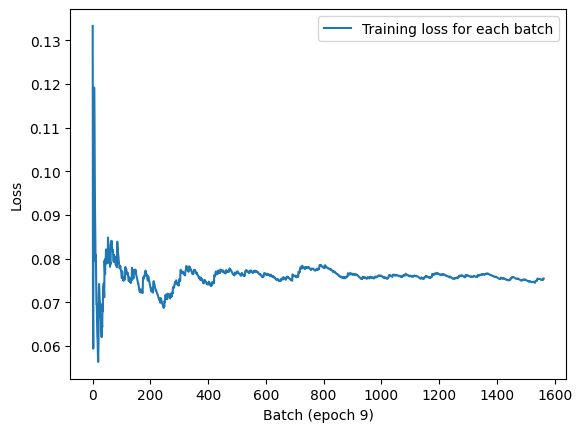

In [10]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, train_labels,
         epochs=10, 
         callbacks=[LossHistory()],
         validation_data=(val_images, val_labels))

### TensorBoard 콜백

In [17]:
import os

tensorboard_dir = '/kaggle/working/tensorboard'
os.makedirs(tensorboard_dir, exist_ok=True)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8645 - loss: 0.4480 - val_accuracy: 0.9582 - val_loss: 0.1428
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9510 - loss: 0.1665 - val_accuracy: 0.9667 - val_loss: 0.1199
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9624 - loss: 0.1284 - val_accuracy: 0.9727 - val_loss: 0.1024
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9675 - loss: 0.1141 - val_accuracy: 0.9746 - val_loss: 0.0953
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9715 - loss: 0.0967 - val_accuracy: 0.9752 - val_loss: 0.0946
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9761 - loss: 0.0902 - val_accuracy: 0.9772 - val_loss: 0.0887
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9760 - loss: 0.0875 - val_accuracy: 0.9789 - val_loss: 0.0858
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9774 - loss: 0.0805 -

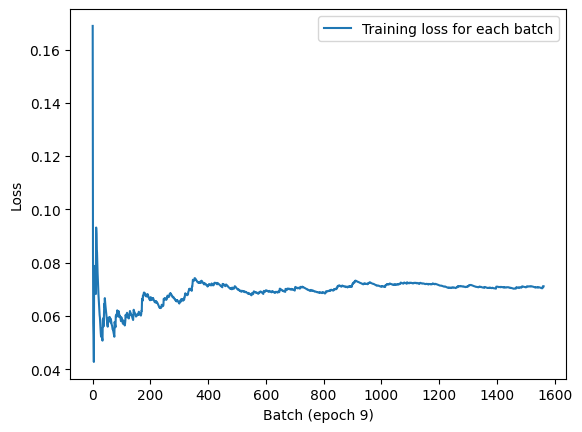

In [19]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(
    log_dir="/kaggle/working/tensorboard",
)
model.fit(train_images, train_labels,
         epochs=10, 
         callbacks=[LossHistory()],
         validation_data=(val_images, val_labels))

## 발표 기록 - 조별 발표 시 작성 예정

## 회고

앞서 배웠던 예제 중에 기억이 맞는다면 RMSE를 그냥 수식 처리해서 사용했던 것 같은데, Metric 클래스를 상속한 RMSE 클래스를 만들어 일관된 평가 지표를 사용할 수 있게 되었습니다.   
또한 기존에는 EarlyStopping 이라는 것이 있다는 정도만 알고 사용했었는데, 콜백의 일종임을 알게 되었습니다.   
아쉬운 점이 있다면 마지막에 텐서보드 인터페이스에서 훈련과 평가 지표를 실시간 그래프로 모니터링하는 실습이 있었는데 노트북을 작성한 kaggle 환경에서는 텐서보드 인터페이스가 실행이 안 되는 것 같아 아쉬움이 남습니다.